/tmp/ipykernel_4068950/1453550646.py:170: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gpt_weights = torch.load(gpt_ckpt, map_location="cpu")


[Info] N_vocab=512, N_valid=16384, N_train=16384
[Info] teacher acc on this valid set: 6086/16384 = 0.3715
[Info] Computing triangle-interval widths (U* - L*) ...
[Info] Basic statistics of widths:
  mean   = 0.406870
  median = 0.372876
  max    = 1.049841
  min    = 0.091414
[Info] Visualizing some correctly-predicted tests ...


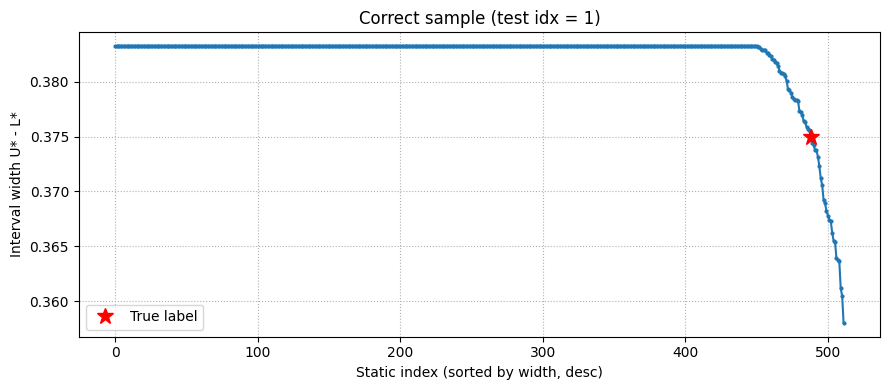

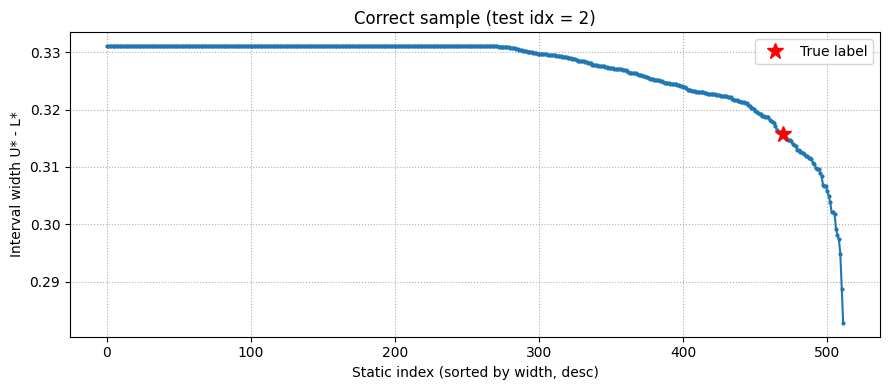

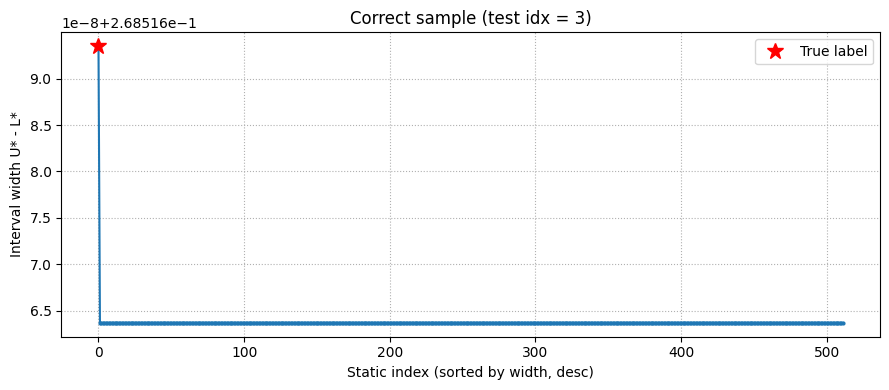

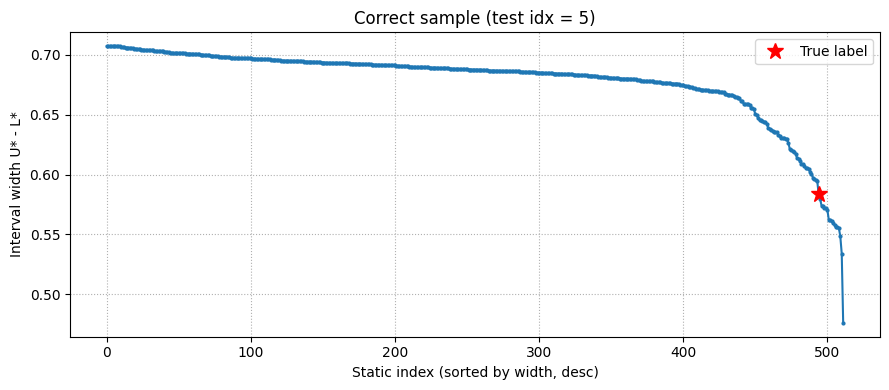

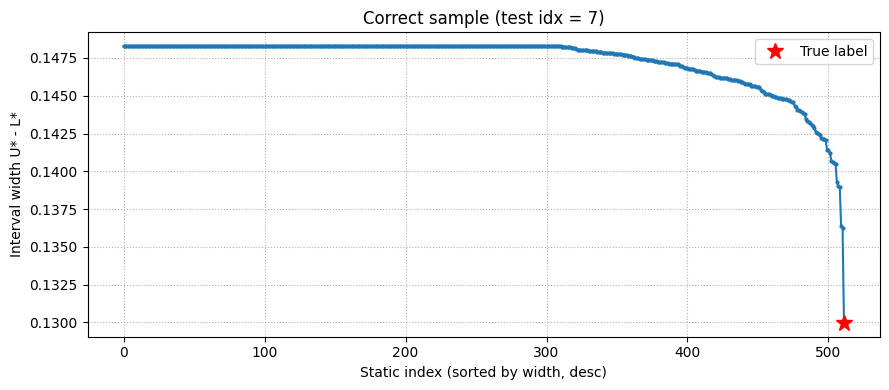

[Info] Visualizing some wrongly-predicted tests ...


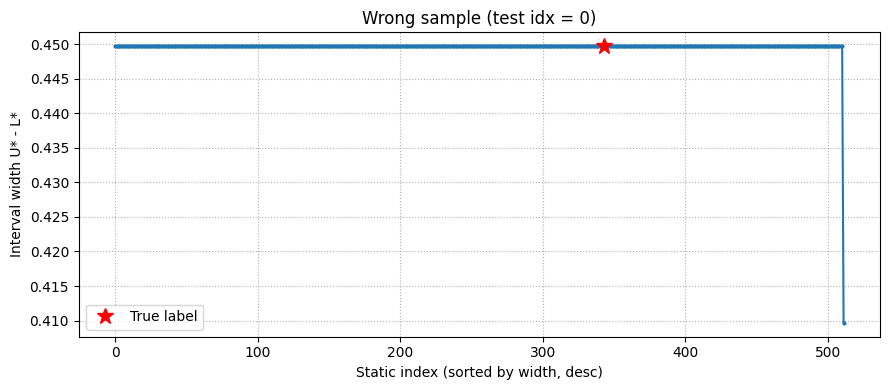

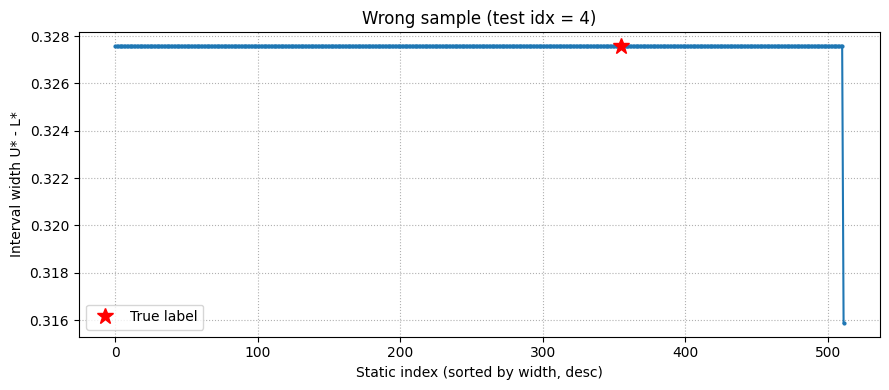

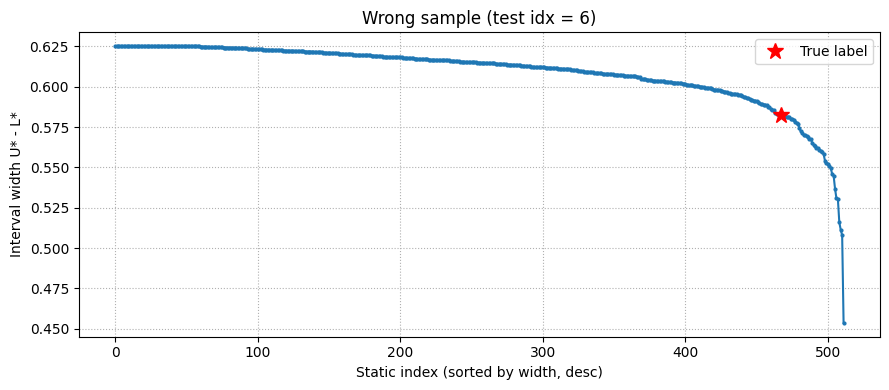

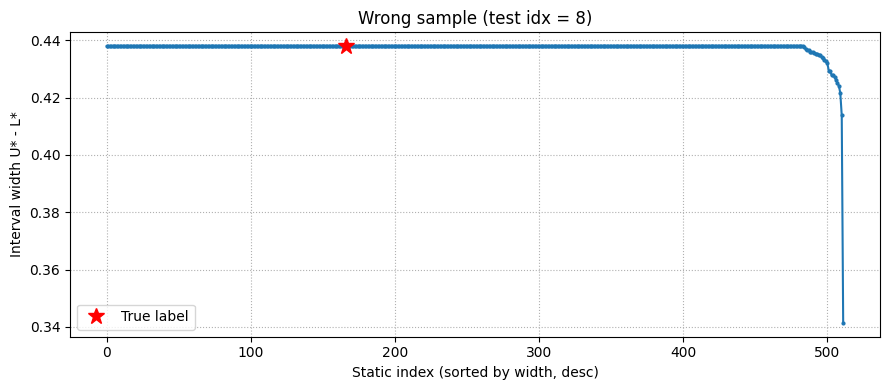

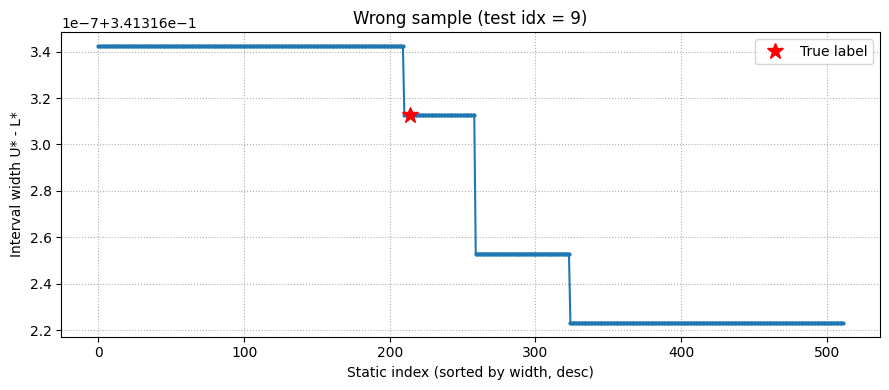

[Info] Correct vs Wrong at true label width stats:
  Correct mean = 0.346586
  Wrong   mean = 0.412347


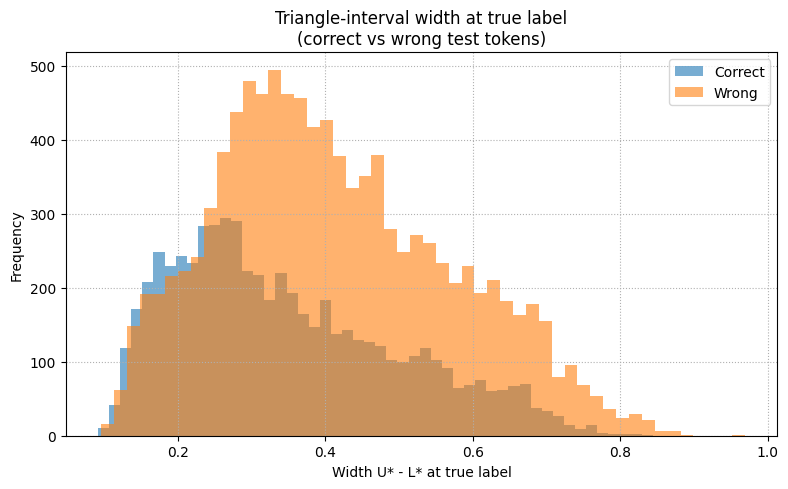

In [2]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"


# -----------------------------
# 度量：teacher 空间中的距离
# -----------------------------
def pairwise_dist(a: torch.Tensor, b: torch.Tensor) -> torch.Tensor:
    """
    a: (Na, d), b: (Nb, d)
    假设 a, b 都是 unit vector
    d(u, v) = (1 - <u, v>) / 2 ∈ [0, 1]
    """
    return torch.sqrt((1 - a @ b.T) / 2) 


# -----------------------------
# 计算三角不等式区间宽度 U - L
# -----------------------------
def compute_triangle_interval_width(
    query_emb: torch.Tensor,
    train_emb: torch.Tensor,
    static_emb: torch.Tensor,
    block_q: int = 512,
    block_s: int = 512,
    block_t: int = 512,
) -> torch.Tensor:
    """
    三重分块版本，避免构造 (Bq, Nt, Bs) 这种超大张量。

    query_emb : (Nq, d)  test 向量
    train_emb : (Nt, d)  train 向量
    static_emb: (Ns, d)  static/vocab 向量

    返回:
        widths: (Nq, Ns)，每个 (t, j) = U_{tj}^* - L_{tj}^*
    """
    device = query_emb.device
    Nq = query_emb.shape[0]
    Nt = train_emb.shape[0]
    Ns = static_emb.shape[0]

    widths = torch.zeros((Nq, Ns), device=device)

    for qs in range(0, Nq, block_q):
        qe = min(qs + block_q, Nq)
        q = query_emb[qs:qe]                 # (Bq, d)

        # 注意：L/U 是这一批 query x 当前 static-block 的局部结果
        for ss in range(0, Ns, block_s):
            se = min(ss + block_s, Ns)
            s = static_emb[ss:se]            # (Bs, d)

            # 初始化：L 取 0（后续 max），U 取 +inf（后续 min）
            Bq = q.shape[0]
            Bs = s.shape[0]
            L = torch.zeros((Bq, Bs), device=device)
            U = torch.full((Bq, Bs), float("inf"), device=device)

            # 对 train 维再分块
            for ts in range(0, Nt, block_t):
                te = min(ts + block_t, Nt)
                t_block = train_emb[ts:te]   # (Bn, d)

                # d(t, x_i) 和 d(x_i, s_j)
                d_tx_block = pairwise_dist(q, t_block)    # (Bq, Bn)
                d_xs_block = pairwise_dist(t_block, s)    # (Bn, Bs)

                # 当前 train-block 上的局部 diff / sum
                # 形状: (Bq, Bn, Bs)
                diff_block = d_tx_block.unsqueeze(-1) - d_xs_block.unsqueeze(0)
                ssum_block = d_tx_block.unsqueeze(-1) + d_xs_block.unsqueeze(0)

                # 在本 block 的 i 上做 max/min，得到 (Bq, Bs)
                L_block = diff_block.abs().max(dim=1).values
                U_block = ssum_block.min(dim=1).values

                # 跨 block 聚合
                L = torch.maximum(L, L_block)
                U = torch.minimum(U, U_block)

                # 释放中间显存（如果显存紧张可以主动清理）
                del d_tx_block, d_xs_block, diff_block, ssum_block, L_block, U_block

            widths[qs:qe, ss:se] = U - L

    return widths




# -----------------------------
# 单个 test 的误差曲线（这里误差 = 宽度 W）
# -----------------------------
def plot_width_curve_for_test(
    widths_row: torch.Tensor,  # (Ns,)
    true_label: int,
    title: str = ""
):
    """
    对某个 test token：
    - widths_row: 对所有 static 的 U-L
    - true_label: 该 test 的标签（static index）
    """
    Ns = widths_row.shape[0]
    w = widths_row

    # 从大到小排序
    order = torch.argsort(w, descending=True)
    w_sorted = w[order].cpu().numpy()

    x = np.arange(Ns)

    plt.figure(figsize=(9, 4))
    plt.plot(x, w_sorted, "-o", markersize=2)
    plt.xlabel("Static index (sorted by width, desc)")
    plt.ylabel("Interval width U* - L*")
    plt.title(title)
    plt.grid(True, linestyle=":")

    # 找到标签 static 在排序中的位置
    pos = (order == true_label).nonzero(as_tuple=True)[0].item()
    plt.plot(pos, w_sorted[pos], "r*", markersize=12, label="True label")
    plt.legend()
    plt.tight_layout()
    plt.show()


# -----------------------------
# 直方图：预测正确 vs 预测错误
# 这里误差 = 每个 test 在真实标签 static 上的宽度 W_{t, y_t}
# -----------------------------
def plot_hist_width(correct_width: torch.Tensor, wrong_width: torch.Tensor):
    plt.figure(figsize=(8, 5))
    plt.hist(correct_width.cpu().numpy(), bins=50, alpha=0.6, label="Correct")
    plt.hist(wrong_width.cpu().numpy(),  bins=50, alpha=0.6, label="Wrong")
    plt.legend()
    plt.xlabel("Width U* - L* at true label")
    plt.ylabel("Frequency")
    plt.title("Triangle-interval width at true label\n(correct vs wrong test tokens)")
    plt.grid(True, linestyle=":")
    plt.tight_layout()
    plt.show()


# -----------------------------
# 主程序
# -----------------------------
if __name__ == "__main__":

    # ==== 1. 超参数 & 路径 ====
    N_vocab = 512
    best_valid_epochs = {
        65 : 9999,
        512: 2000,
        384: 3000,
        768: 2000,
        1024: 2000,
    }

    epoch = best_valid_epochs[N_vocab]

    # teacher vocab embedding (token embedding table)
    gpt_ckpt = f"../ckpt/gpt/voc{N_vocab}_normfixed20_b256_iters_{epoch}.pth"
    gpt_weights = torch.load(gpt_ckpt, map_location="cpu")
    vocab_emb = gpt_weights["token_embedding_table.weight"]       # (N_vocab, d)
    vocab_emb = F.normalize(vocab_emb, dim=-1)

    # test / valid cache
    valid_N = 16384
    valid_path = (
        f"voc{N_vocab}_normfixed20_b256_iters_{epoch}_"
        f"valid{valid_N}_cache_last.pth"
    )
    valid_data = load_file(valid_path, device="cpu")
    query_emb = valid_data["emb"]     # (N_valid, d)
    query_y   = valid_data["y"].long()   # (N_valid,)

    # train cache
    pos_ratio = 1.0
    train_size = 16384
    train_path = (
        f"voc{N_vocab}_normfixed20_b256_iters_{epoch}_"
        f"ps{pos_ratio}_train{train_size}_cache_last.pth"
    )
    train_data = load_file(train_path, device="cpu")
    train_emb = train_data["emb"]     # (N_train, d)

    # 归一化
    query_emb = F.normalize(query_emb, dim=-1)
    train_emb = F.normalize(train_emb, dim=-1)

    # 放到 device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    vocab_emb = vocab_emb.to(device)
    query_emb = query_emb.to(device)
    train_emb = train_emb.to(device)
    query_y   = query_y.to(device)

    print(f"[Info] N_vocab={N_vocab}, N_valid={query_emb.shape[0]}, N_train={train_emb.shape[0]}")

    # ==== 2. teacher 自己的预测，用来区分“预测正确/错误”的 test ====
    # logits 不需要缩放就可以 argmax，保持与你之前 20*inner 的形式一致也可以
    logits = 20.0 * (query_emb @ vocab_emb.T)     # (N_valid, N_vocab)
    pred_label = logits.argmax(dim=-1)           # (N_valid,)

    correct_mask = (pred_label == query_y)
    wrong_mask   = ~correct_mask
    correct_ids = correct_mask.nonzero(as_tuple=True)[0]
    wrong_ids   = wrong_mask.nonzero(as_tuple=True)[0]

    print(f"[Info] teacher acc on this valid set: "
          f"{correct_ids.numel()}/{query_emb.shape[0]}"
          f" = {correct_ids.numel()/query_emb.shape[0]:.4f}")

    # ==== 3. 计算三角不等式区间宽度 W_{tj} = U^* - L^* ====
    print("[Info] Computing triangle-interval widths (U* - L*) ...")
    widths = compute_triangle_interval_width(query_emb, train_emb, vocab_emb)
    # widths: (N_valid, N_vocab)

    print("[Info] Basic statistics of widths:")
    print(f"  mean   = {widths.mean().item():.6f}")
    print(f"  median = {widths.median().item():.6f}")
    print(f"  max    = {widths.max().item():.6f}")
    print(f"  min    = {widths.min().item():.6f}")

    # ==== 4. 抽样若干 test，可视化它们的 W_{tj} 曲线 ====
    def visualize_some_tests(indices: torch.Tensor, count: int, prefix: str):
        if indices.numel() == 0:
            print(f"[Warn] No {prefix} samples.")
            return
        sel = indices[:count]
        for idx in sel:
            idx = idx.item()
            plot_width_curve_for_test(
                widths_row=widths[idx],
                true_label=int(query_y[idx].item()),
                title=f"{prefix} sample (test idx = {idx})"
            )

    print("[Info] Visualizing some correctly-predicted tests ...")
    visualize_some_tests(correct_ids, count=5, prefix="Correct")

    print("[Info] Visualizing some wrongly-predicted tests ...")
    visualize_some_tests(wrong_ids, count=5, prefix="Wrong")

    # ==== 5. 对“真实标签 static”上的宽度做直方图 ====
    # W_{t, y_t}
    per_test_width_at_label = widths[torch.arange(query_emb.shape[0], device=device), query_y]

    correct_width = per_test_width_at_label[correct_ids]
    wrong_width   = per_test_width_at_label[wrong_ids]

    print("[Info] Correct vs Wrong at true label width stats:")
    print(f"  Correct mean = {correct_width.mean().item():.6f}")
    print(f"  Wrong   mean = {wrong_width.mean().item():.6f}")

    plot_hist_width(correct_width, wrong_width)
